In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models import resnet18

EMBEDDING_SIZE = 256

model = resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, EMBEDDING_SIZE)


In [2]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class AlbumDataset(Dataset):
    def __init__(self, root_dir, anchor_transform, positive_transform):
        self.root_dir = root_dir
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir)]
        self.anchor_transform = anchor_transform
        self.positive_transform = positive_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        # Apply separate transforms for anchor and positive
        anchor = self.anchor_transform(image)
        positive = self.positive_transform(image)
        
        return anchor, positive, idx

# Augmentation transforms for anchor and positive
anchor_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random crop
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

positive_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),  # Random crop
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),  # Distortion
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
    transforms.RandomChoice([
        transforms.Compose([]),  # No-op (do nothing)
        transforms.RandomRotation((90, 90)),
        transforms.RandomRotation((180, 180)),
        transforms.RandomRotation((270, 270))
    ]),
    transforms.RandomRotation(degrees=10),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Data loader
dataset = AlbumDataset(root_dir='album_covers_512/', anchor_transform=anchor_transform, positive_transform=positive_transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers = 3)

In [ ]:
import torch.optim as optim
from torch.nn.functional import normalize
from tqdm import tqdm

# Triplet loss
triplet_loss_fn = nn.TripletMarginLoss(margin=1.0, p=2)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

losses = []

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for anchors, positives, indices in tqdm(dataloader, desc = "batches"):
        anchors, positives = anchors.to(device), positives.to(device)

        # Forward pass
        anchor_emb = normalize(model(anchors), p=2, dim=1)
        positive_emb = normalize(model(positives), p=2, dim=1)

        # Generate random negatives from the batch
        negatives = anchors[torch.randperm(len(anchors))].to(device)
        negative_emb = normalize(model(negatives), p=2, dim=1)

        # Compute triplet loss
        loss = triplet_loss_fn(anchor_emb, positive_emb, negative_emb)
        epoch_loss += loss.item()

        # Backprop and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(epoch_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader):.4f}")

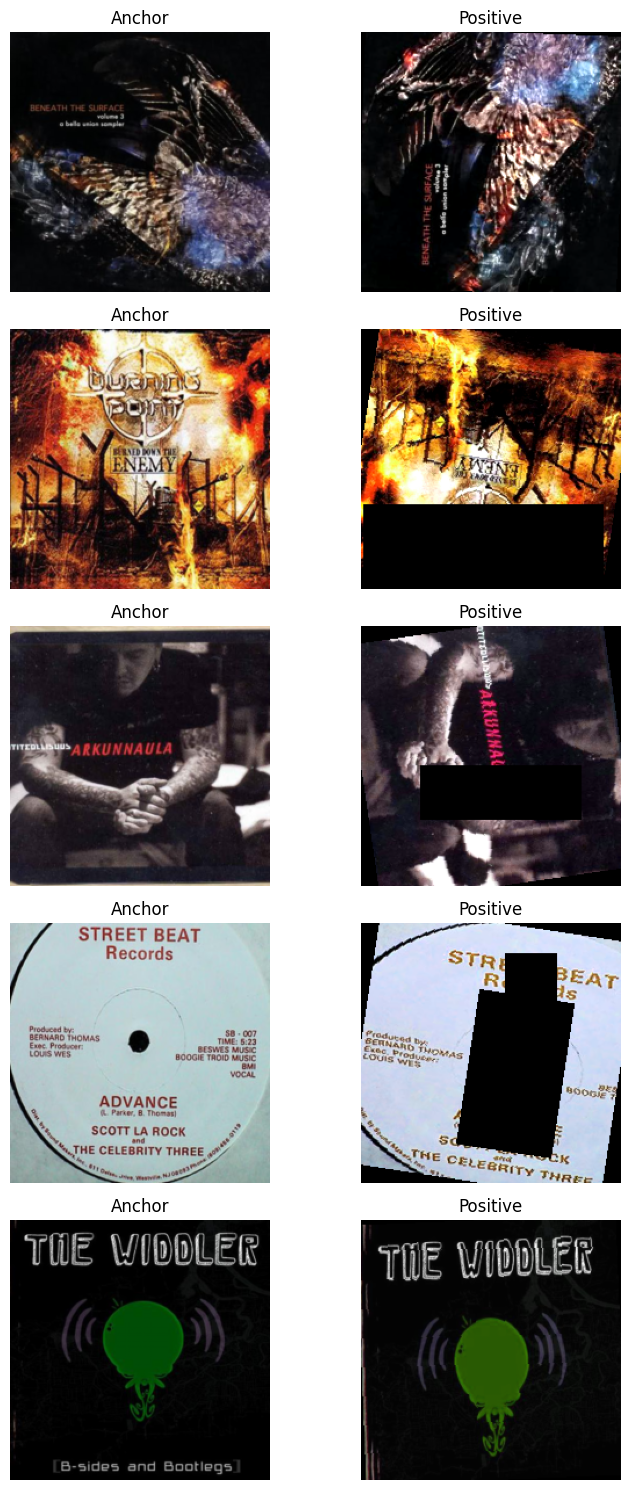

In [6]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# Function to visualize a batch of images
def visualize_augmentations(dataloader, num_samples=5):
    # Get a batch of data
    data_iter = iter(dataloader)
    anchors, positives, _ = next(data_iter)
    
    # Limit to num_samples
    anchors = anchors[:num_samples]
    positives = positives[:num_samples]
    
    # Unnormalize images for visualization
    def unnormalize(img):
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img = img * std + mean
        return torch.clamp(img, 0, 1)  # Clamp values between 0 and 1

    # Plot original and augmented images
    fig, axs = plt.subplots(num_samples, 2, figsize=(8, num_samples * 3))
    for i in range(num_samples):
        anchor_img = unnormalize(anchors[i]).permute(1, 2, 0).cpu().numpy()
        positive_img = unnormalize(positives[i]).permute(1, 2, 0).cpu().numpy()

        axs[i, 0].imshow(anchor_img)
        axs[i, 0].set_title("Anchor")
        axs[i, 0].axis("off")

        axs[i, 1].imshow(positive_img)
        axs[i, 1].set_title("Positive")
        axs[i, 1].axis("off")

    plt.tight_layout()
    plt.savefig('album_comp_1.png')
    plt.show()

# Call the function
visualize_augmentations(dataloader)

In [ ]:
torch.save(model.state_dict(), "tuned.pth")

## Validation

In [ ]:
import os
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

class AlbumValidationDataset:
    def __init__(self, root_dir, transform=None):
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir)]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, os.path.basename(img_path)  # Return image and filename

# Validation transform
validation_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to model input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create the validation dataset
validation_dataset = AlbumValidationDataset(root_dir='data/', transform=validation_transform)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, shuffle=False)

In [ ]:
def extract_embeddings(model, dataloader, device):
    model.eval()
    embeddings = []
    filenames = []
    with torch.no_grad():
        for images, names in dataloader:
            images = images.to(device)
            output = model(images)  # Extract embeddings
            embeddings.append(output.cpu())
            filenames.extend(names)
    return torch.cat(embeddings), filenames

# Load the trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# model.load_state_dict(torch.load('resnet18_triplet.pth'))  # Load trained weights

# Extract embeddings
embeddings, filenames = extract_embeddings(model, validation_loader, device)

In [ ]:
def reduce_dimensionality(embeddings, method='pca', n_components=2):
    embeddings_np = embeddings.numpy()
    if method == 'pca':
        reducer = PCA(n_components=n_components)
    elif method == 'tsne':
        reducer = TSNE(n_components=n_components, perplexity=10, random_state=42)
    reduced_embeddings = reducer.fit_transform(embeddings_np)
    return reduced_embeddings

# Reduce to 2D or 3D
reduced_embeddings = reduce_dimensionality(embeddings, method='tsne', n_components=3)

def plot_embeddings(reduced_embeddings, filenames, n_components=2):
    plt.figure(figsize=(10, 8))
    if n_components == 2:
        plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=50, alpha=0.7, cmap='viridis')
        for i, filename in enumerate(filenames):
            plt.annotate(filename, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=8, alpha=0.6)
        plt.title("2D Embedding Visualization")
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")
    elif n_components == 3:
        from mpl_toolkits.mplot3d import Axes3D
        ax = plt.figure().add_subplot(111, projection='3d')
        ax.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], reduced_embeddings[:, 2], s=50, alpha=0.7, cmap='viridis')
        plt.title("3D Embedding Visualization")
    plt.grid()
    plt.show()

# Plot the embeddings
plot_embeddings(reduced_embeddings, filenames, n_components=3)  # Change to 3 for 3D visualization

# Compare this to the raw resnet18

In [ ]:
original_resnet = resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1).to(device)
original_embeddings, original_filenames = extract_embeddings(original_resnet, validation_loader, device)
original_reduced_embeddings = reduce_dimensionality(original_embeddings[:256], method='tsne', n_components=3)
plot_embeddings(original_reduced_embeddings, original_filenames, n_components=3)